In [28]:
import os

from models.vae import VariationalAutoencoder
from models.utils.loaders import load_mnist
import pandas as pd
import numpy as np
from tensorflow.python.framework.ops import disable_eager_execution
from matplotlib import pyplot as plt

disable_eager_execution()

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

N_DENSE = 2
L=8
TRAINING_FRACTION = 0.8

In [2]:
user = 1
if user == 1:
    prefix_s3 = "/home/owen/"
    prefix_data = "/home/owen/repos/"
elif user == 2:
    prefix_data = "/Users/omyers/repos/"

In [3]:
# run params
SECTION = 'vae'
RUN_ID = '0002'
#DATA_NAME = 'digits'
DATA_NAME = 'ising'
RUN_FOLDER = '{}/run/{}/'.format(os.getcwd(), SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.makedirs(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #


In [4]:
df_bins = pd.read_csv("{prefix_data}z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/bins_L-{L}-T-1-5.txt".format(L=L,prefix_data=prefix_data), sep="\t")
df_conf = pd.read_csv("{prefix_data}z3support/data/SpinMLData/2DIsing/L-{L}/L-{L}-T-1-5/spinConfigs_L-{L}-T-1-5.txt".format(L=L,prefix_data=prefix_data), delimiter=r"\s+", header=None)

In [5]:
df_bins = df_bins[df_bins[' T '] != ' T ']

In [6]:
df_bins = df_bins.astype(
    {
        " T ": int,
        " binNum": int,
    }
)

## Get the temp and magnatization into the configuration dataframe

In [7]:
df_conf["T"] = df_bins[" T "]

In [8]:
mean_col = df_conf[0].copy()
for i in range(1, L):
    mean_col += df_conf[i]

mean_col /= L

In [9]:
df_conf["M"] = mean_col

In [10]:
filterned_confs = df_conf

In [11]:
filterned_confs.head()

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,T,M
0,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
2,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
3,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
4,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0


We need the data in the format: `(x_train, y_train), (x_test, y_test)`

In [35]:
train_with_meta_info = filterned_confs.sample(frac=TRAINING_FRACTION, axis=0)
test_with_meta_info = filterned_confs.drop(index=train.index)

In [36]:
train = train_with_meta_info.drop(["T","M"], axis=1)
test = test_with_meta_info.drop(["T","M"], axis=1)

# Check what MNIST data looked like

In [13]:
(x_train, y_train), (x_test, y_test) = load_mnist()

In [14]:
np.shape(x_train)

(60000, 28, 28, 1)

In [15]:
np.shape(x_train)

(60000, 28, 28, 1)

## Make our data the same

In [37]:
train.to_numpy().shape

(4000, 64)

In [38]:
x = train.to_numpy().reshape(-1,L,L,1)
x_test = test.to_numpy().reshape(-1,L,L,1)

In [39]:
np.array([[1,1,1,1], [2,2,3,3], [4,4,5,5]]).reshape(-1,2,2,1)

array([[[[1],
         [1]],

        [[1],
         [1]]],


       [[[2],
         [2]],

        [[3],
         [3]]],


       [[[4],
         [4]],

        [[5],
         [5]]]])

In [40]:
x = x.astype(float)

In [41]:
x.shape

(4000, 8, 8, 1)

## Run Convolutional VAE

In [42]:
vae = VariationalAutoencoder(
    input_dim = (L,L,1)
    , encoder_conv_filters = [8,8,16]
    , encoder_conv_kernel_size = [3,3,3]
    , encoder_conv_strides = [1,2,1]
    , decoder_conv_t_filters = [16,8,1]
    , decoder_conv_t_kernel_size = [3,3,3]
    , decoder_conv_t_strides = [1,2,1]
    , z_dim = 2
)

In [43]:
LEARNING_RATE = 0.0005
R_LOSS_FACTOR = 1000

In [44]:
vae.compile(LEARNING_RATE, R_LOSS_FACTOR)

In [45]:
BATCH_SIZE = 16
EPOCHS = 20
PRINT_EVERY_N_BATCHES = 100
INITIAL_EPOCH = 0

In [46]:
vae.train(     
    x
    , batch_size = BATCH_SIZE
    , epochs = EPOCHS
    , run_folder = RUN_FOLDER
    , print_every_n_batches = PRINT_EVERY_N_BATCHES
    , initial_epoch = INITIAL_EPOCH
)

Train on 4000 samples
Epoch 1/20
1696/4000 [===========>..................] - ETA: 0s - loss: 1106.5449 - vae_r_loss: 1093.5992 - vae_kl_loss: 12.9455

/home/owen/repos/z3support/pythonenv/lib/python3.8/site-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


3440/4000 [========================>.....] - ETA: 0s - loss: 998.8228 - vae_r_loss: 985.5740 - vae_kl_loss: 13.2489  
Epoch 1: saving model to /home/owen/repos/z3support/notebooks/run/vae/0002_ising/weights/weights-001-973.74.h5

Epoch 1: saving model to /home/owen/repos/z3support/notebooks/run/vae/0002_ising/weights/weights.h5
4000/4000 [==============================] - 1s 135us/sample - loss: 973.7382 - vae_r_loss: 960.7895 - vae_kl_loss: 12.9486 - lr: 5.0000e-04
Epoch 2/20
3568/4000 [=========================>....] - ETA: 0s - loss: 807.5687 - vae_r_loss: 801.6429 - vae_kl_loss: 5.9252
Epoch 2: saving model to /home/owen/repos/z3support/notebooks/run/vae/0002_ising/weights/weights-002-807.31.h5

Epoch 2: saving model to /home/owen/repos/z3support/notebooks/run/vae/0002_ising/weights/weights.h5
4000/4000 [==============================] - 0s 91us/sample - loss: 807.3146 - vae_r_loss: 801.4774 - vae_kl_loss: 5.8368 - lr: 5.0000e-04
Epoch 3/20
3568/4000 [=========================>....

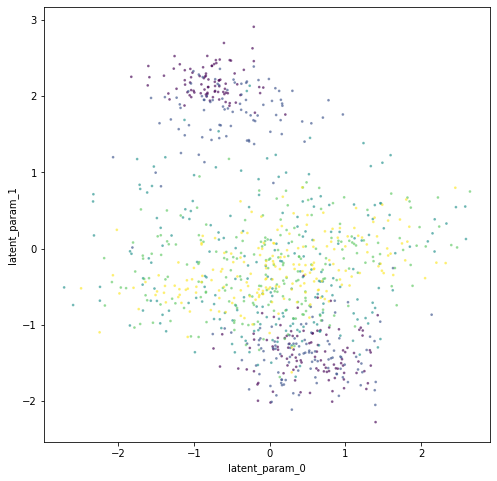

In [84]:
figsize = 8

z_points = vae.encoder.predict(x_test)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
#plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.scatter(z_points[:, 0] , z_points[:, 1], c=test_with_meta_info['T'], alpha=0.5, s=3)
plt.xlabel("latent_param_0")
plt.ylabel("latent_param_1")
plt.show()

In [54]:
test_with_meta_info[test_with_meta_info['T'] < 2]

,0,1,2,3,4,5,6,7,8,9,...,56,57,58,59,60,61,62,63,T,M
6,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
12,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1.0,1.0
23,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1.0,1.0
28,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
31,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
969,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1.0,1.0
979,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
982,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1,...,-1,-1,-1,-1,-1,-1,-1,-1,1.0,-1.0
986,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1.0,1.0


In [56]:
test_with_meta_info[test_with_meta_info['T'] < 2].index

Int64Index([  6,  12,  23,  28,  31,  32,  35,  38,  41,  53,
            ...
            933, 947, 956, 961, 968, 969, 979, 982, 986, 992],
           dtype='int64', length=187)

In [78]:
#len(x_test)
test_with_meta_info = test_with_meta_info.reset_index()

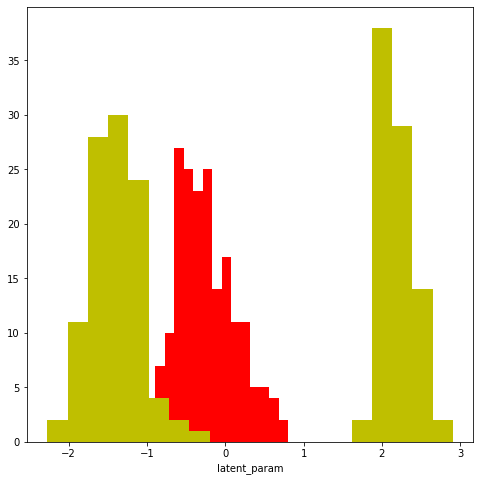

In [95]:
plt.figure(figsize=(figsize, figsize))
plt.hist(z_points[:, 1][test_with_meta_info[test_with_meta_info['T'] > 4].index], color='r', bins=20)
plt.hist(z_points[:, 1][test_with_meta_info[test_with_meta_info['T'] < 2].index], color='y', bins=20)
plt.xlabel("latent_param")
plt.savefig("{}/s3-bucket/reproduction/fig_2/vae_cnn_latent_param_hist_l{}.png".format(prefix_s3, L))

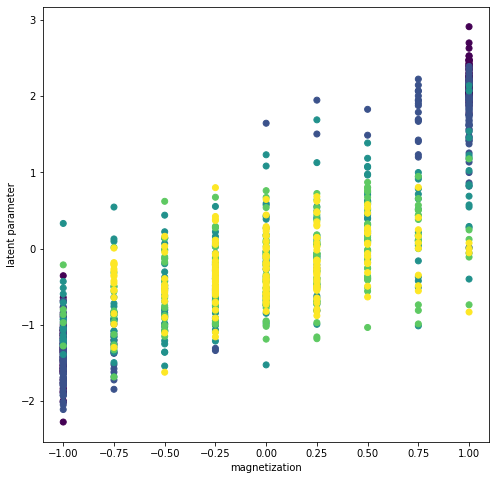

In [96]:
plt.figure(figsize=(figsize, figsize))
plt.scatter(test_with_meta_info['M'], z_points[:,1], c=test_with_meta_info['T'])
plt.xlabel("magnetization")
plt.ylabel("latent parameter")
plt.savefig("{}/s3-bucket/reproduction/fig_2/vae_cnn_scatter_latent_vs_mag_color_by_t_l{}.png".format(prefix_s3, L))